##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Estimator で線形モデルを構築する

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/estimator/linear"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

> 警告: 新しいコードには Estimators は推奨されません。Estimators は `v1.Session` スタイルのコードを実行しますが、これは正しく記述するのはより難しく、特に TF 2 コードと組み合わせると予期しない動作をする可能性があります。Estimators は、[互換性保証](https://tensorflow.org/guide/versions)の対象となりますが、セキュリティの脆弱性以外の修正は行われません。詳細については、[移行ガイド](https://tensorflow.org/guide/migrate)を参照してください。

## 概要

このエンドツーエンドのウォークスルーでは、`tf.estimator` API を使用してロジスティック回帰モデルをトレーニングします。このモデルはほかのより複雑なアルゴリズムの基準としてよく使用されます。

注意: Keras によるロジスティック回帰の例は[こちら](https://tensorflow.org/guide/migrate/tutorials/keras/regression)からご覧いただけます。これは、本チュートリアルよりも推奨されます。


## セットアップ

In [2]:
!pip install sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)


  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https

In [3]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

## Titanic データセットを読み込む

Titanic データセットを使用して、性別、年齢、船室クラスなどの特性に基づき、（やや悪趣味ではありますが）乗船者の生存を予測することを目標とします。

In [4]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

2024-01-11 21:53:58.890761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 21:53:58.890806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 21:53:58.892379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## データを確認する

データセットには、次の特徴量が含まれます。

In [6]:
dftrain.head()

sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y

In [7]:
dftrain.describe()

age  n_siblings_spouses       parch        fare
count  627.000000          627.000000  627.000000  627.000000
mean    29.631308            0.545455    0.379585   34.385399
std     12.511818            1.151090    0.792999   54.597730
min      0.750000            0.000000    0.000000    0.000000
25%     23.000000            0.000000    0.000000    7.895800
50%     28.000000            0.000000    0.000000   15.045800
75%     35.000000            1.000000    0.000000   31.387500
max     80.000000            8.000000    5.000000  512.329200

トレーニングセットと評価セットには、それぞれ 627 個と 264 個の例があります。

In [8]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

乗船者の大半は 20 代から 30 代です。

<Axes: >

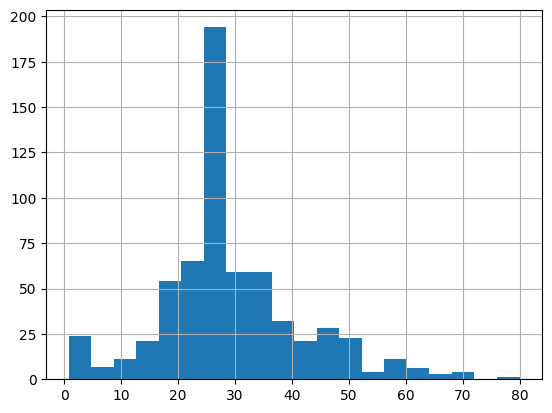

In [9]:
dftrain.age.hist(bins=20)

男性の乗船者数は女性の乗船者数の約 2 倍です。

<Axes: ylabel='sex'>

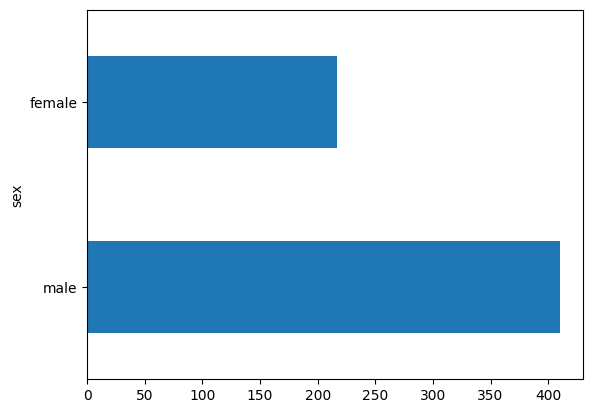

In [10]:
dftrain.sex.value_counts().plot(kind='barh')

乗船者の大半は「3 等」の船室クラスを利用していました。

<Axes: ylabel='class'>

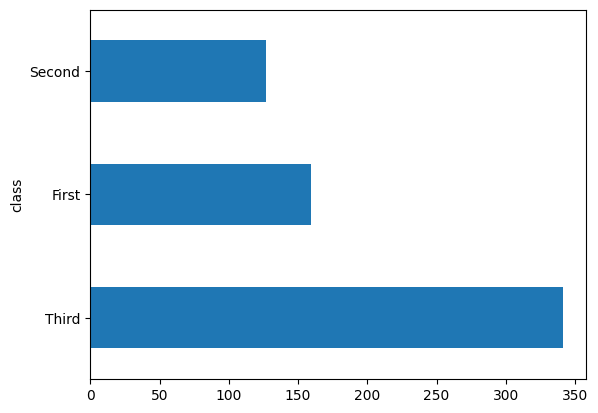

In [11]:
dftrain['class'].value_counts().plot(kind='barh')

女性は男性よりも生存する確率がはるかに高く、これは明らかにモデルの予測特徴量です。

Text(0.5, 0, '% survive')

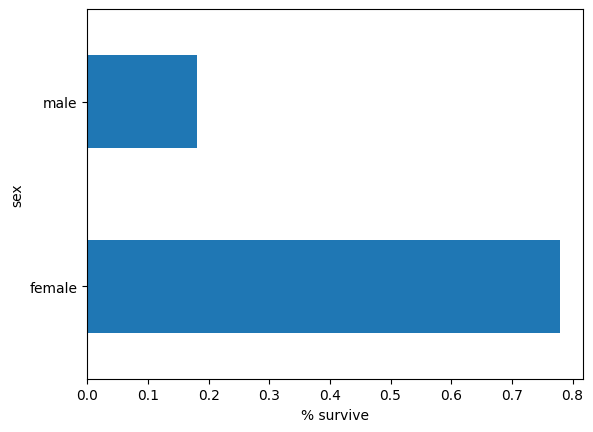

In [12]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## モデルの特徴量エンジニアリング

> 警告: このチュートリアルで説明されている tf.feature_columns モジュールは、新しいコードにはお勧めしません。Keras 前処理レイヤーがこの機能をカバーしています。移行手順については、[特徴量カラムの移行](https://www.tensorflow.org/guide/migrate/migrating_feature_columns)ガイドをご覧ください。tf.feature_columns モジュールは、TF1 Estimators で使用するために設計されました。[互換性保証](https://tensorflow.org/guide/versions)の対象となりますが、セキュリティの脆弱性以外の修正は行われません。

Estimator は、モデルがどのように各行の入力特徴量を解釈すべきかを説明する[特徴量カラム](https://www.tensorflow.org/tutorials/structured_data/feature_columns)というシステムを使用しています。Estimator は数値入力のベクトルを期待しており、*特徴量カラム*にはモデルがどのように各特徴量を変換すべきかが記述されています。

効率的なモデルを学習するには、適切な特徴カラムの選択と作成が鍵となります。特徴量カラムは、元の特徴量 `dict` の生の入力の 1 つ（*基本特徴量カラム*）または 1 つ以上の基本カラムに定義された変換を使って作成された新規カラム（*派生特徴量カラム*）のいずれかです。

線形 Estimator は、数値特徴量とカテゴリカル特徴量の両方を利用します。特徴量カラムは TensorFlow Estimator と機能し、その目的はモデリングに使用される特徴量を定義することにあります。さらに、One-Hot エンコーディング、正規化、およびバケット化などのいくつかの特徴量エンジニアリング機能を提供します。

### 基本特徴量カラム

In [13]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


`input_function` は、入力パイプラインをストリーミングの手法でフィードする `tf.data.Dataset` にデータを変換する方法を指定します。`tf.data.Dataset` は、dataframe や csv 形式ファイルなど、複数のソースを取ることができます。

In [14]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

次のようにデータセットを検査できます。

In [15]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Second' b'Third' b'Third' b'Third' b'First' b'Third' b'Second' b'Third'
 b'Third' b'First']

A batch of Labels: [1 0 0 0 1 1 0 0 0 1]


また、`tf.keras.layers.DenseFeatures` レイヤーを使用して、特定の特徴量カラムの結果を検査することもできます。

In [16]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[ 3.],
       [21.],
       [32.],
       [59.],
       [44.],
       [ 4.],
       [24.],
       [10.],
       [28.],
       [28.]], dtype=float32)

`DenseFeatures` は密なテンソルのみを受け入れ、それを最初にインジケータカラムに変換する必要のあるカテゴリカラムを検査します。

In [17]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

すべての基本特徴量をモデルに追加したら、モデルをトレーニングすることにしましょう。モデルのトレーニングは、 `tf.estimator` API を使ってコマンド 1 つで行います。

In [18]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7386364, 'accuracy_baseline': 0.625, 'auc': 0.8361494, 'auc_precision_recall': 0.78821784, 'average_loss': 0.47708422, 'label/mean': 0.375, 'loss': 0.47104964, 'precision': 0.64705884, 'prediction/mean': 0.3915048, 'recall': 0.6666667, 'global_step': 200}


### 派生特徴量カラム

精度が 75% に達しました。それぞれの基本特徴量カラムを個別に使用しても、データを説明するには不足している場合があります。たとえば、年齢とラベルの間の相関関係は、性別が変われば異なることがあります。そのため、`gender="Male"` と `gender="Female"` で単一モデルの重みのみを把握しただけでは、すべての年齢と性別の組み合わせをキャプチャすることはできません（`gender="Male"` と `age="30"` と `gender="Male"` と `age="40"` を区別するなど）。

さまざまな特徴量の組み合わせの間の違いを把握するには、*相互特徴量カラム*をモデルに追加できます（また、相互カラムの前に年齢カラムをバケット化できます）。

In [19]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


組み合わせた特徴量をモデルに追加したら、モデルをもう一度トレーニングしましょう。

In [20]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.8426691, 'auc_precision_recall': 0.79368746, 'average_loss': 0.47478184, 'label/mean': 0.375, 'loss': 0.46697915, 'precision': 0.6666667, 'prediction/mean': 0.40963757, 'recall': 0.64646465, 'global_step': 200}


これで、77.6% の精度に達しました。基本特徴量のみでトレーニングした場合よりわずかに改善されています。ほかの特徴量と変換を使用して、さらに改善されるか確認してみましょう！

このトレーニングモデルを使用して、評価セットからある乗船者に予測を立てることができます。TensorFlow モデルは、バッチ、コレクション、または例に対してまとめて予測を立てられるように最適化されています。以前は、`eval_input_fn` は評価セット全体を使って定義されていました。

INFO:tensorflow:Calling model_fn.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmpfs/tmp/tmpsa7vq6kw/model.ckpt-200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


<Axes: title={'center': 'predicted probabilities'}, ylabel='Frequency'>

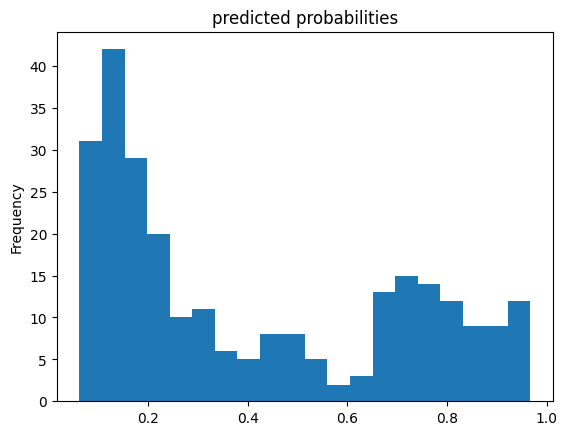

In [21]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

最後に、結果の受信者操作特性（ROC）を見てみましょう。真陽性率と偽陽性率間のトレードオフに関し、より明確な予想を得ることができます。

(0.0, 1.05)

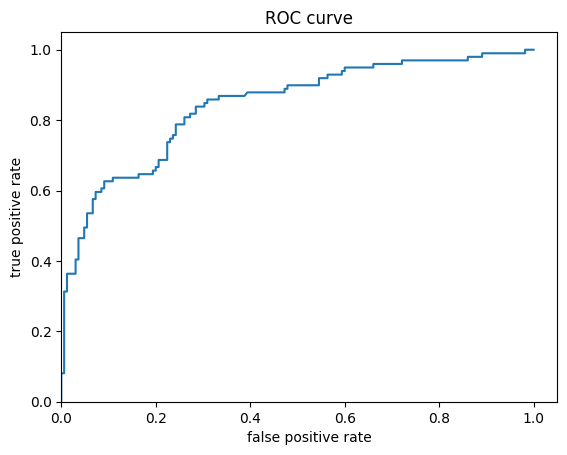

In [22]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)